# **Csomagok behívása**

In [1]:
#Szükséges csomagok és adatbázis importálása
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Input, Concatenate
import numpy as np
import tensorflow as tf
import spacy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Fájlok behívása, ellenőrzése és felkészítése

In [2]:
# Betölteni padded sequences, tokenizer, és számokat
padded_train = np.load('/content/padded_train04.npy')
padded_test = np.load('/content/padded_sajat.npy')

# Tokenizer visszatöltése
with open('/content/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Címkék betöltése (real = 1, fake = 0)
train_file = '/content/train_negyedik.csv'
test_file = '/content/own_negyedik.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

labels_train = df_train['label'].values
labels_test = df_test['label'].values

# Betölteni embedding mátrixot
embedding_matrix = np.load('/content/embedding_matrix.npy')

# Ellenőrzés
print(f"Train padded sequences shape: {padded_train.shape}")
print(f"Test padded sequences shape: {padded_test.shape}")
print(f"Train labels shape: {labels_train.shape}")
print(f"Test labels shape: {labels_test.shape}")

Train padded sequences shape: (59520, 600)
Test padded sequences shape: (40, 600)
Train labels shape: (59520,)
Test labels shape: (40,)


In [3]:
# Max szókincs és szekvencia hossz
MAX_VOCAB_SIZE = 25000
MAX_LENGTH = 600
EMBEDDING_DIM = 300  # GloVe 300d

# input shape
MAX_SEQUENCE_LENGTH = padded_train.shape[1]

# Szöveges input (LSTM/GRU bemenet)
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
embedding_layer = Embedding(
    input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE),
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)(text_input)

model_output = embedding_layer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [4]:
MAX_SEQUENCE_LENGTH = padded_train.shape[1]  # Train hossz
EMBEDDING_DIM = embedding_matrix.shape[1]  # GloVe embeddings

# 10%-os validációs halmaz leválasztása a tanító adatokból
padded_train_final, padded_val, y_train_final, y_val = train_test_split(
    padded_train, labels_train, test_size=0.1, random_state=42
)
# Float32-re konvertálás TensorFlow kompatibilitás miatt
padded_train_final = np.array(padded_train_final, dtype=np.float32)
padded_val = np.array(padded_val, dtype=np.float32)
padded_test = np.array(padded_test, dtype=np.float32)
y_train_final = np.array(y_train_final, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(labels_test, dtype=np.float32)

# Korai leállítás beállítása
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# GRU MODELL 4. ELŐFELDOLGOZÁSNÁL


### Modell lefuttatása

In [5]:
# GRU Modell

def create_gru_model(trainable_embeddings=True):
    # Szöveges input
    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
    text_embedding = Embedding(
        input_dim=min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE),  # Ensure within vocab limit
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=trainable_embeddings  # Toggle trainability
    )(text_input)

    # GRU rétegek
    gru_out = GRU(128, return_sequences=True, dropout=0.3)(text_embedding)
    gru_out = Dropout(0.3)(gru_out)  # Dropout réteg az első GRU után
    gru_out = GRU(64,return_sequences=True, dropout=0.3)(gru_out)
    gru_out = Dropout(0.3)(gru_out)
    gru_out = GRU(32, dropout=0.3)(gru_out)

    # Kimeneti réteg
    output = Dense(1, activation='sigmoid')(gru_out)  # Binary classification

    # Modell létrehozása
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Modell létrehozása (Trainable)
gru_trainable = create_gru_model(trainable_embeddings=True)

gru_trainable.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 600, 300)       │     7,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 600, 128)       │       165,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 600, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 600, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 600, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,711,809 (29.42 MB)

 Trainable params: 7,711,809 (29.42 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Inicializálás
n_runs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
test_losses, test_accuracies = [], []

all_preds, all_probs, all_true = [], [], []

results2 = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

confusion_matrices = []

# Többszöri futtatás
for i in range(n_runs):
    print(f"\nFutás {i+1}/{n_runs}")

    gru_trainable = create_gru_model(trainable_embeddings=True)

    history = gru_trainable.fit(
        padded_train_final, y_train_final,
        validation_data=(padded_val, y_val),
        epochs=10,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=0
    )

    # Tanulási görbékhez szükséges adatok
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])

    # Teszt pontosság/veszteség
    loss, acc = gru_trainable.evaluate(padded_test, y_test, verbose=0)
    test_losses.append(loss)
    test_accuracies.append(acc)

    # Predikció
    gru_y_prob = gru_trainable.predict(padded_test)
    gru_y_pred = (gru_y_prob > 0.5).astype(int)

    all_preds.append(gru_y_pred.flatten())
    all_probs.append(gru_y_prob.flatten())
    all_true.append(y_test.flatten())

    # Metrikák
    results2['accuracy'].append(accuracy_score(y_test, gru_y_pred))
    results2['precision'].append(precision_score(y_test, gru_y_pred))
    results2['recall'].append(recall_score(y_test, gru_y_pred))
    results2['f1_score'].append(f1_score(y_test, gru_y_pred))

    # konf
    cm = confusion_matrix(y_test, gru_y_pred)
    confusion_matrices.append(cm)

# Aggregált adatok
y_true_all = np.concatenate(all_true)
y_pred_all = np.concatenate(all_preds)
y_prob_all = np.concatenate(all_probs)
padded_test_repeated = np.tile(padded_test, (n_runs, 1))


Futás 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step

Futás 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step

Futás 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Futás 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step

Futás 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step


In [7]:
df_metrics2 = pd.DataFrame(results2)
print("\n Metrikák statisztikája (10 futás):")
print(df_metrics2.describe().T)


 Metrikák statisztikája (10 futás):
           count      mean       std       min       25%       50%       75%  \
accuracy     5.0  0.830000  0.073739  0.775000  0.775000  0.800000  0.850000   
precision    5.0  0.804973  0.059482  0.761905  0.772727  0.789474  0.791667   
recall       5.0  0.870000  0.103682  0.750000  0.800000  0.850000  0.950000   
f1_score     5.0  0.835052  0.075074  0.769231  0.780488  0.809524  0.863636   

                max  
accuracy   0.950000  
precision  0.909091  
recall     1.000000  
f1_score   0.952381  


## GRU modell ábrák

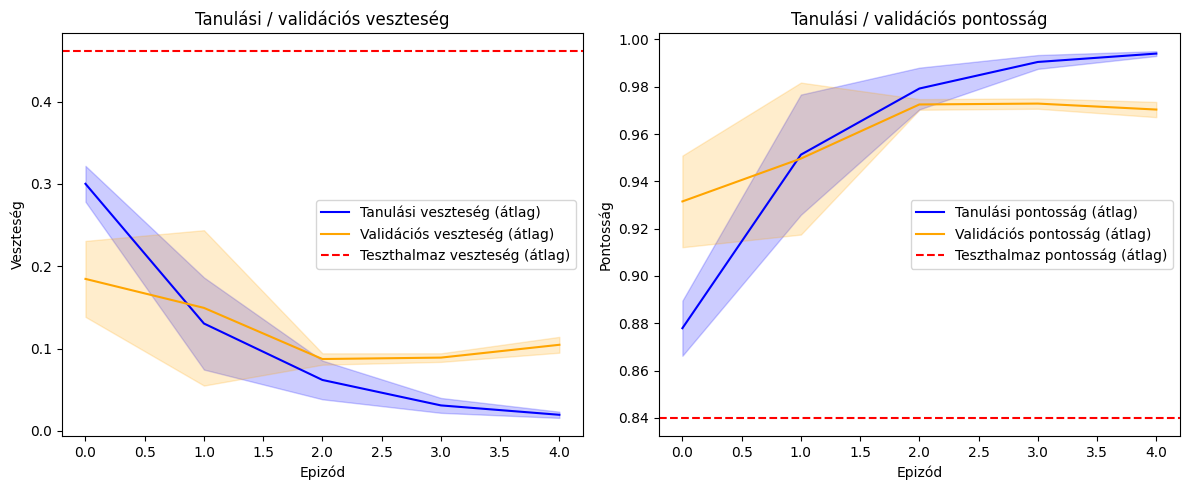

In [8]:
# Egységesítés (early stopping miatt lehetnek eltérések)
min_epochs = min(len(run) for run in train_losses)

train_losses_np = np.array([run[:min_epochs] for run in train_losses])
val_losses_np = np.array([run[:min_epochs] for run in val_losses])
train_accuracies_np = np.array([run[:min_epochs] for run in train_accuracies])
val_accuracies_np = np.array([run[:min_epochs] for run in val_accuracies])
epochs = min_epochs

# Ábrák
plt.figure(figsize=(12, 5))

# Veszteség
plt.subplot(1, 2, 1)
plt.plot(train_losses_np.mean(axis=0), label='Tanulási veszteség (átlag)', color='blue')
plt.fill_between(range(epochs), train_losses_np.mean(axis=0) - train_losses_np.std(axis=0),
                 train_losses_np.mean(axis=0) + train_losses_np.std(axis=0), alpha=0.2, color='blue')
plt.plot(val_losses_np.mean(axis=0), label='Validációs veszteség (átlag)', color='orange')
plt.fill_between(range(epochs), val_losses_np.mean(axis=0) - val_losses_np.std(axis=0),
                 val_losses_np.mean(axis=0) + val_losses_np.std(axis=0), alpha=0.2, color='orange')
plt.axhline(np.mean(test_losses), color='red', linestyle='--', label='Teszthalmaz veszteség (átlag)')
plt.xlabel('Epizód'); plt.ylabel('Veszteség'); plt.title('Tanulási / validációs veszteség')
plt.legend()

# Pontosság
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_np.mean(axis=0), label='Tanulási pontosság (átlag)', color='blue')
plt.fill_between(range(epochs), train_accuracies_np.mean(axis=0) - train_accuracies_np.std(axis=0),
                 train_accuracies_np.mean(axis=0) + train_accuracies_np.std(axis=0), alpha=0.2, color='blue')
plt.plot(val_accuracies_np.mean(axis=0), label='Validációs pontosság (átlag)', color='orange')
plt.fill_between(range(epochs), val_accuracies_np.mean(axis=0) - val_accuracies_np.std(axis=0),
                 val_accuracies_np.mean(axis=0) + val_accuracies_np.std(axis=0), alpha=0.2, color='orange')
plt.axhline(np.mean(test_accuracies), color='red', linestyle='--', label='Teszthalmaz pontosság (átlag)')
plt.xlabel('Epizód'); plt.ylabel('Pontosság'); plt.title('Tanulási / validációs pontosság')
plt.legend()
plt.tight_layout()
plt.show()


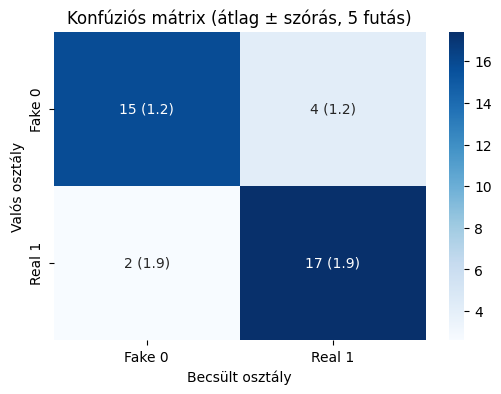

In [9]:

import numpy as np

conf_matrices_array = np.array(confusion_matrices)

cm_mean = np.mean(conf_matrices_array, axis=0)
cm_std = np.std(conf_matrices_array, axis=0)

# Formázás megjelenítéshez: "átlag (szórás)"
annot = np.empty_like(cm_mean, dtype=object)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{int(cm_mean[i, j])} ({cm_std[i, j]:.1f})"

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm_mean, annot=annot, fmt='', cmap="Blues",
            xticklabels=["Fake 0", "Real 1"],
            yticklabels=["Fake 0", "Real 1"])
plt.xlabel('Becsült osztály')
plt.ylabel('Valós osztály')
plt.title('Konfúziós mátrix (átlag ± szórás, 5 futás)')
plt.show()

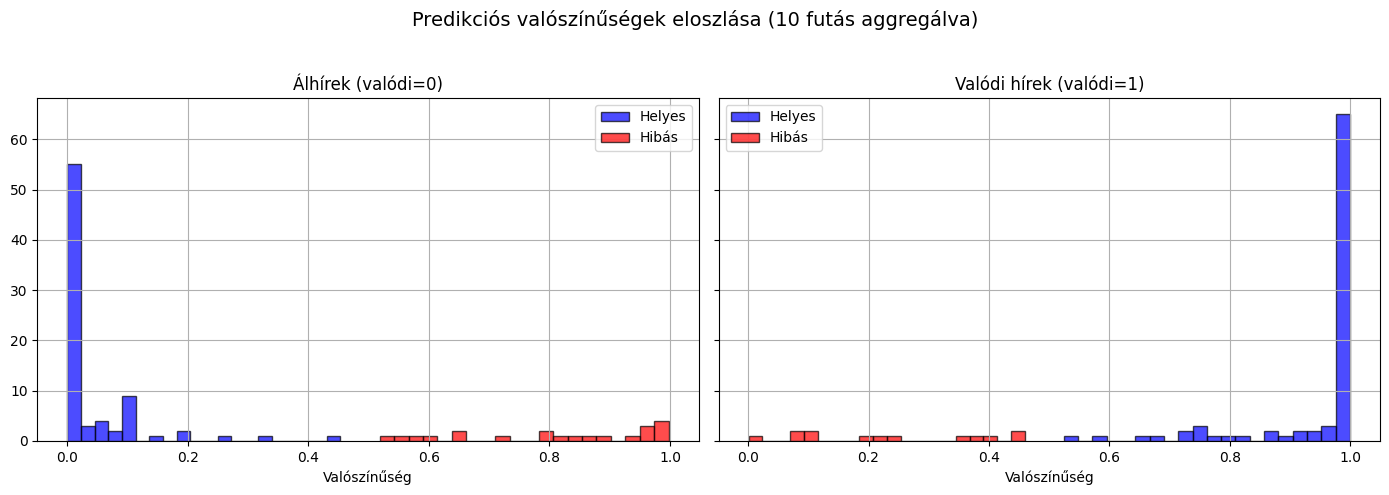

In [10]:
correct_real = y_prob_all[(y_true_all == 0) & (y_pred_all == 0)]
incorrect_real = y_prob_all[(y_true_all == 0) & (y_pred_all != 0)]
correct_fake = y_prob_all[(y_true_all == 1) & (y_pred_all == 1)]
incorrect_fake = y_prob_all[(y_true_all == 1) & (y_pred_all != 1)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(correct_real, bins=20, alpha=0.7, label="Helyes", color="blue", edgecolor="black")
axes[0].hist(incorrect_real, bins=20, alpha=0.7, label="Hibás", color="red", edgecolor="black")
axes[0].set_title("Álhírek (valódi=0)"); axes[0].set_xlabel("Valószínűség"); axes[0].legend(); axes[0].grid(True)

axes[1].hist(correct_fake, bins=20, alpha=0.7, label="Helyes", color="blue", edgecolor="black")
axes[1].hist(incorrect_fake, bins=20, alpha=0.7, label="Hibás", color="red", edgecolor="black")
axes[1].set_title("Valódi hírek (valódi=1)"); axes[1].set_xlabel("Valószínűség"); axes[1].legend(); axes[1].grid(True)

plt.suptitle("Predikciós valószínűségek eloszlása (10 futás aggregálva)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [11]:
df_results_full = pd.DataFrame({
    "Valódi címke": y_true_all,
    "Prediktált címke": y_pred_all
})
df_misclassified = df_results_full[df_results_full["Valódi címke"] != df_results_full["Prediktált címke"]].copy()
misclassified_indices = df_misclassified.index.to_numpy()
misclassified_sequences = padded_test_repeated[misclassified_indices]
misclassified_texts = tokenizer.sequences_to_texts(misclassified_sequences)
misclassified_texts_cleaned = [
    " ".join([word for word in text.split() if word.lower().strip() not in ["<oov>", "oov", "[oov]", "(oov)"]])
    for text in misclassified_texts
]
df_misclassified.insert(0, "Hiba típusa", df_misclassified.apply(
    lambda row: "Hamis pozitív (FP)" if row["Valódi címke"] == 0 else "Hamis negatív (FN)", axis=1))
df_misclassified["Szöveg"] = misclassified_texts_cleaned
df_misclassified["Predikció valószínűsége"] = np.round(y_prob_all[misclassified_indices], 4)
df_misclassified.to_csv("felrebesorolt_peldak_aggregalt_gru.csv", index=False, encoding="utf-8")

pd.set_option("display.max_colwidth", None)
display(df_misclassified.head(20))


Hiba típusa  Valódi címke  Prediktált címke  \
23   Hamis pozitív (FP)           0.0                 1   
33   Hamis pozitív (FP)           0.0                 1   
43   Hamis negatív (FN)           1.0                 0   
55   Hamis negatív (FN)           1.0                 0   
59   Hamis negatív (FN)           1.0                 0   
61   Hamis pozitív (FP)           0.0                 1   
63   Hamis pozitív (FP)           0.0                 1   
64   Hamis pozitív (FP)           0.0                 1   
66   Hamis pozitív (FP)           0.0                 1   
73   Hamis pozitív (FP)           0.0                 1   
83   Hamis negatív (FN)           1.0                 0   
92   Hamis negatív (FN)           1.0                 0   
95   Hamis negatív (FN)           1.0                 0   
99   Hamis negatív (FN)           1.0                 0   
101  Hamis pozitív (FP)           0.0                 1   
102  Hamis pozitív (FP)           0.0                 1   
103  Hamis pozitív (FP)           0.0                 1   
106  Hamis pozitív (FP)           0.0                 1   
113  Hamis pozitív (FP)           0.0                 1   
123  Hamis negatív (FN)           1.0                 0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    